## Compute ALT-allele effects at each site

In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

NUCLEOTIDE_TRANSFORMER_MODEL = '500M_human_ref' #@param['500M_human_ref', '500M_1000G', '2B5_1000G', '2B5_multi_species']
SEQUENCE_LENGTH = 501

DIRECTORY = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/enhancer-characteristics-enrichment-subset-inference/{NUCLEOTIDE_TRANSFORMER_MODEL}.{SEQUENCE_LENGTH}' 

from numpy import linalg as LA
import pandas as pd 
import numpy as np 

import pysam 

import sys 
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

from read_model import read_model
from bases import BASES 
from kmer import CpG 
from pack_unpack import pack

MCHALE_MODEL = read_model(f"{CONSTRAINT_TOOLS}/dist/model-germline-grch38-Nonly.kmerSize-3.trainSet-noncoding.json")

In [2]:
def compute_heat_map(window, embeddings): 
  chromosome = window['chromosome']
  start = int(window['start'])
  end = int(window['end'])

  with pysam.FastaFile(MCHALE_MODEL['genome']) as genome:
    # "fetch" API: https://pysam.readthedocs.io/en/latest/api.html?highlight=fasta#pysam.FastaFile
    # Note that fetch(region=region) does not work if the coordinates in "region" contains commas
    # Workaround is to parse "region" into "chromosome", "start", "end": 
    sequence = genome.fetch(chromosome, start, end)    
    sequence = sequence.upper()

  distances_for_all_sites = []
  mask = np.ones((len(BASES), len(sequence)))
  for site_index, REF in enumerate(sequence): 
    REF_index = BASES.index(REF)
    mask[REF_index, site_index] = 0
    REF_embedding = embeddings[REF_index, site_index]
    distances_for_site = []
    for allele_index in range(len(BASES)): 
      embedding = embeddings[allele_index, site_index]
      delta = REF_embedding - embedding

      # section A.5.2 of https://www.biorxiv.org/content/10.1101/2023.01.11.523679v2
      # details metrics that could be used to quantify distance between embeddings: 
      #    (i) the L1 distance (Manhattan), 
      #    (ii) the L2 distance (Euclidean), 
      #    (iii) the cosine similarity 
      #    (iv) the dot-product (not normalized cosine similarity) 
      distance = LA.norm(delta, 2) 

      distances_for_site.append(distance)
    distances_for_all_sites.append(distances_for_site)
  distances_for_all_sites = np.array(distances_for_all_sites)
  heat_map = distances_for_all_sites.T 

  return heat_map, mask # both indexed as BASES X [site1, site2, ...]

def fetch_window(window_index): 
  window = pd.read_csv(f'{DIRECTORY}/window-{window_index}.bed', sep='\t')
  assert len(window) == 1
  window = window.iloc[0]
  return window

def fetch_embeddings(window_index): 
  embeddings_filename = f'{DIRECTORY}/window-{window_index}.embeddings.{NUCLEOTIDE_TRANSFORMER_MODEL}.{SEQUENCE_LENGTH}.npy'
  embeddings = np.load(embeddings_filename)
  return embeddings

def compute_heat_map_wrapper(window_index): 
  window = fetch_window(window_index)
  embeddings = fetch_embeddings(window_index)
  return compute_heat_map(window, embeddings)

compute_heat_map_wrapper(window_index=0)

(array([[0.       , 0.       , 0.       , ..., 1.9941801, 0.       ,
         1.9081959],
        [2.595312 , 3.805649 , 2.8977833, ..., 1.6820358, 2.273474 ,
         2.2385428],
        [2.640824 , 2.933897 , 3.8397076, ..., 1.8109329, 1.4833192,
         0.       ],
        [3.4823732, 3.5007   , 2.3707097, ..., 0.       , 2.2311282,
         1.897106 ]], dtype=float32),
 array([[0., 0., 0., ..., 1., 0., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 0.],
        [1., 1., 1., ..., 0., 1., 1.]]))

## Fetch CpG sites 

In [3]:
from kmer import fetch_kmers

def compute_CpG_sites(window): 
  region=pack(window['chromosome'], window['start'], window['end'])

  with pysam.FastaFile(MCHALE_MODEL['genome']) as genome:
    CpG_sites = [
      1 if CpG(kmer) else 0 
      for kmer in fetch_kmers(region, genome, kmer_size=3, log=True) # upper case
    ]
  
  return np.array([CpG_sites])

def compute_CpG_sites_wrapper(window_index): 
  window = fetch_window(window_index)
  return compute_CpG_sites(window)

compute_CpG_sites_wrapper(window_index=0)

Sequence for region chr1:5814000-5815000:
aaataatgataagaatcacatgatacaagcagtaagagggtgaggctgaaaccacgggaggatgaggaaggactagggtttgggCACAGCTGCCCTGAGG...
Iterating over region chr1:5814000-5815000 ...
Interrogated 1000/1000 sites in region chr1:5814000-5815000
Number of sites in chr1:5814000-5815000 containing unspecified bases: 0/1000


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Fetch SNVs 

In [4]:
from snvs import fetch_SNVs
from colorize import print_json

def get_snvs(window): 
  with pysam.TabixFile(MCHALE_MODEL['mutations']) as mutations, pysam.FastaFile(MCHALE_MODEL['genome']) as genome:
    SNVs = fetch_SNVs(
      mutations, 
      genome, 
      region=pack(window['chromosome'], window['start'], window['end']),
      meta=MCHALE_MODEL, 
      number_chromosomes_min=MCHALE_MODEL['numberChromosomesMin']
    )
  return [
    {
      **SNV,
      'position_offset': SNV['position'] - int(window['start']),
      'CpG+': CpG(SNV['kmer'])
    }
    for SNV in SNVs
  ]

def get_snvs_wrapper(window_index): 
  window = fetch_window(window_index)
  return get_snvs(window)

print_json(get_snvs_wrapper(window_index=0))

[
  {
    "chromosome": "chr1",
    "position": 5814033,
    "REF": "A",
    "ALT": "C",
    "number_ALT_chromosomes": 2,
    "number_chromosomes": 152142,
    "kmer": "TAA",
    "position_offset": 33,
    "CpG+": false
  },
  {
    "chromosome": "chr1",
    "position": 5814037,
    "REF": "G",
    "ALT": "C",
    "number_ALT_chromosomes": 1,
    "number_chromosomes": 152066,
    "kmer": "AGG",
    "position_offset": 37,
    "CpG+": false
  },
  {
    "chromosome": "chr1",
    "position": 5814038,
    "REF": "G",
    "ALT": "T",
    "number_ALT_chromosomes": 1,
    "number_chromosomes": 152106,
    "kmer": "GGG",
    "position_offset": 38,
    "CpG+": false
  },
  {
    "chromosome": "chr1",
    "position": 5814040,
    "REF": "T",
    "ALT": "C",
    "number_ALT_chromosomes": 1,
    "number_chromosomes": 151878,
    "kmer": "GTG",
    "position_offset": 40,
    "CpG+": false
  },
  {
    "chromosome": "chr1",
    "position": 5814053,
    "REF": "A",
    "ALT": "G",
    "number_ALT_chr

## Correlate variant-effect predictions with SNVs observed in cohort

zscore quantile: 0.0 - 0.005


Sequence for region chr1:5814000-5815000:
aaataatgataagaatcacatgatacaagcagtaagagggtgaggctgaaaccacgggaggatgaggaaggactagggtttgggCACAGCTGCCCTGAGG...
Iterating over region chr1:5814000-5815000 ...
Interrogated 1000/1000 sites in region chr1:5814000-5815000
Number of sites in chr1:5814000-5815000 containing unspecified bases: 0/1000


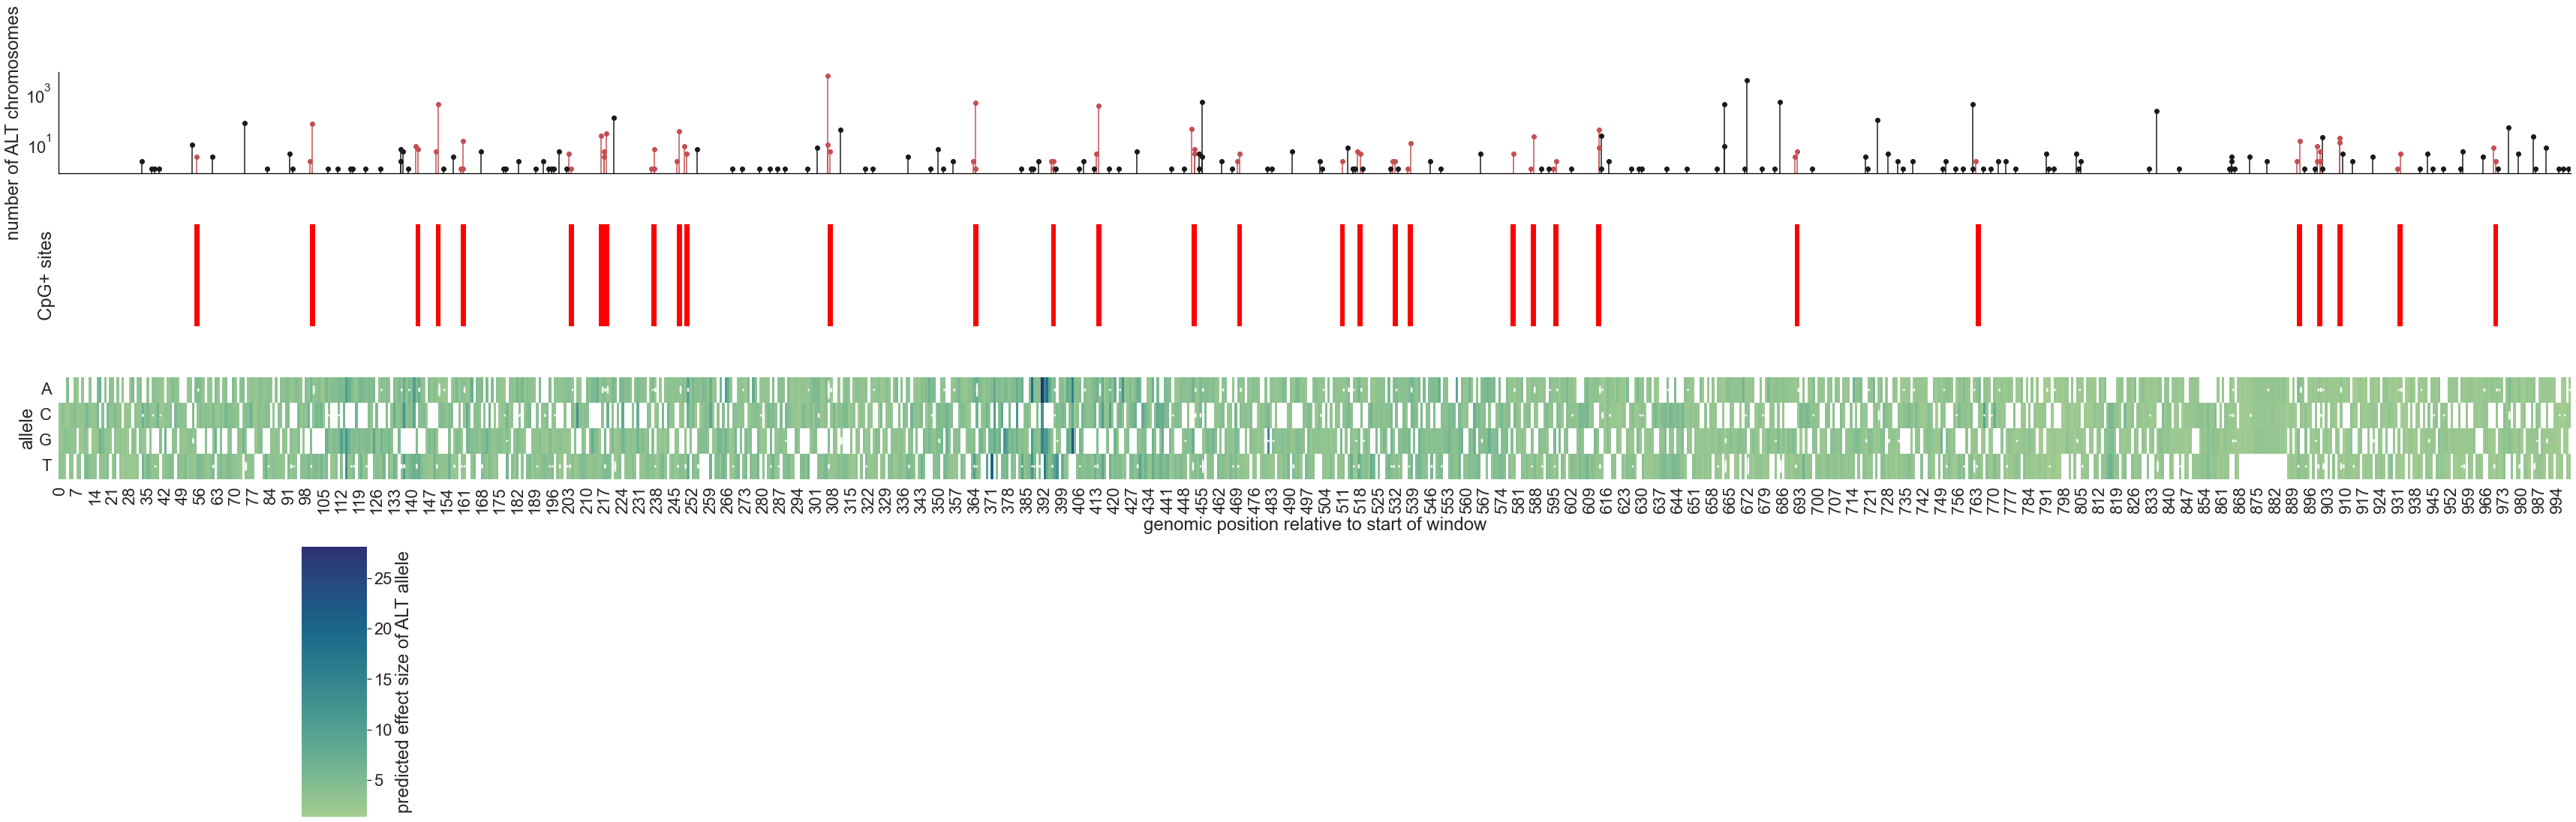

In [5]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set(font_scale=2)

plt.rcParams.update({
  'axes.facecolor': 'white'
})

from matplotlib.collections import PatchCollection
from matplotlib.patches import Ellipse

XLIM = [0, 1000]

def plot_stem(ax, SNVs): 
  x = [SNV['position_offset'] for SNV in SNVs]
  y = [SNV['number_ALT_chromosomes'] for SNV in SNVs]
  CpG = [SNV['CpG+'] for SNV in SNVs]  

  x = np.array(x)
  y = np.array(y)

  ax.stem(x[CpG], y[CpG], linefmt='r-', markerfmt='ro')  
  ax.stem(x[np.logical_not(CpG)], y[np.logical_not(CpG)], linefmt='k-', markerfmt='ko')  
  ax.set_yscale('log')
  ax.set_xlim(XLIM) 
  ax.spines['bottom'].set_color('black')
  ax.spines['left'].set_color('black')
  # ax.set_xlabel('genomic position of SNV relative to start of window')
  ax.set_ylabel('number of ALT chromosomes')
  ax.xaxis.set_tick_params(labelbottom=False)

def create_ellipse(SNV): 
  x = SNV['position_offset'] + 0.5
  y = BASES.index(SNV['ALT']) + 0.5
  log_ALT_count_plus_one = np.log10(SNV['number_ALT_chromosomes']+1)
  log_max_ALT_count_plus_one = np.log10(SNV['number_chromosomes']+1)
  return Ellipse(
    (x,y), 
    width=0.5, 
    height=log_ALT_count_plus_one/log_max_ALT_count_plus_one,
    color='white'
  )

def plot_heat_map(heat_map, mask, ax, fig): 
  # https://seaborn.pydata.org/generated/seaborn.heatmap.html
  sns.heatmap(
      heat_map, 
      ax = ax,
      cmap = sns.color_palette("crest", as_cmap=True), # https://seaborn.pydata.org/tutorial/color_palettes.html
      center = None, 
      annot = False, 
      # fmt = '.3f',
      # linewidths = 1, 
      cbar = True,
      cbar_ax = fig.add_axes([0.2, -0.5, 0.02, 0.5]),
      cbar_kws = {'label': 'predicted effect size of ALT allele'},
      mask = np.logical_not(mask)
  )
  # ax.invert_yaxis()
  ax.set_yticks(np.arange(len(BASES))+0.5)
  ax.set_yticklabels(list(BASES), rotation=0)
  ax.set_xlabel('genomic position relative to start of window')
  ax.set_ylabel('allele')
  ax.set_xlim(XLIM)

def plot_ellipses(SNVs, ax):
  ellipses = [create_ellipse(SNV) for SNV in SNVs]
  # https://stackoverflow.com/a/71675432 : 
  p = PatchCollection(ellipses, alpha=1, match_original=True)
  ax.add_collection(p)
  
def plot_CpG_sites(CpG_sites, ax): 
  # https://seaborn.pydata.org/generated/seaborn.heatmap.html
  sns.heatmap(
      CpG_sites, 
      ax = ax,
      cmap = ['white','red'], # sns.color_palette("crest", as_cmap=True), # https://seaborn.pydata.org/tutorial/color_palettes.html
      center = None, 
      annot = False, 
      # fmt = '.3f',
      # linewidths = 1, 
      cbar = False,
      # cbar_ax = fig.add_axes([0.6, -0.5, 0.02, 0.5]),
      # cbar_kws = {'label': 'CpG+'},
      mask = None
  )
  ax.set_xlim(XLIM)
  ax.set_yticks([])
  ax.set_ylabel('CpG+ sites')

def plot_snvs_and_variant_effects(window_index, threshold_heat_map): 
  window = fetch_window(window_index)
  embeddings = fetch_embeddings(window_index)

  print(f"zscore quantile: {window['negative new chen zscore quantile']}") 

  SNVs = get_snvs(window)
  heat_map, mask = compute_heat_map(window, embeddings)

  if threshold_heat_map: 
    heat_map[heat_map<8] = 0
    heat_map[heat_map>8] = 1

  fig, axes = plt.subplots(3, 1, sharex=True, figsize=(60, 10))
  plot_stem(axes[0], SNVs)  
  plot_CpG_sites(compute_CpG_sites(window), axes[1])
  plot_heat_map(heat_map, mask, axes[2], fig)
  plot_ellipses(SNVs, axes[2])
  fig.subplots_adjust(hspace=0.5)
  
plot_snvs_and_variant_effects(window_index=0, threshold_heat_map=False)

In [6]:
EFFECT_SIZE_THRESHOLD = 11

In [7]:
from scipy.stats import fisher_exact
  
def compute_mean_std(ALT_effect_size, title, log=True): 
  if log: 
    print('##############################')
    print(title)

  mean_ALT_effect_size = np.mean(ALT_effect_size)
  if log: print(f'mean effect size of ALT alleles: {mean_ALT_effect_size}')

  std_ALT_effect_size = np.std(ALT_effect_size)
  if log: print(f'std of effect size of ALT alleles: {std_ALT_effect_size}')

  return mean_ALT_effect_size, std_ALT_effect_size

def compute_fishers_exact_test(table, title): 
  print('##############################')
  print(title)
  print(table)

  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html
  result = fisher_exact(table, alternative='greater')
  odds_ratio, pvalue = result.statistic, result.pvalue
  print(f'odds ratio: {odds_ratio}')
  print(f'pvalue: {pvalue}')

def compute_fishers_exact_tests(ALT_effect_size, ALT_exists_in_cohort): 
  ALT_is_strong = ALT_effect_size>EFFECT_SIZE_THRESHOLD
  
  compute_fishers_exact_test(    
    table = np.array(pd.crosstab(np.logical_not(ALT_is_strong), ALT_exists_in_cohort)), 
    title = 'test for negative selection:\n are alleles not observed in cohort enriched for large-effect alleles?'
  )

  compute_fishers_exact_test(    
    table = np.array(pd.crosstab(np.logical_not(ALT_is_strong), np.logical_not(ALT_exists_in_cohort))), 
    title = 'test for positive selection:\n are alleles observed in cohort enriched for large-effect alleles?'
  )

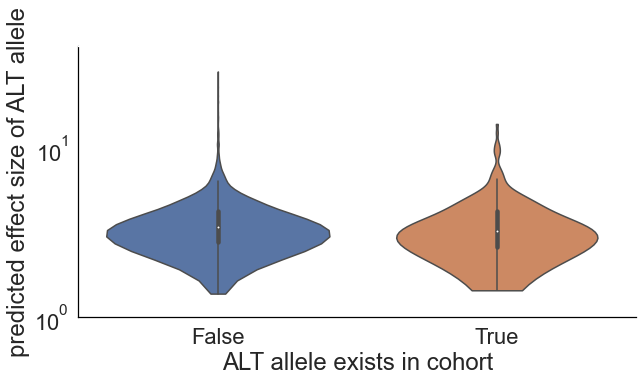

zscore quantile: 0.0 - 0.005
##############################
all
mean effect size of ALT alleles: 3.6980984210968018
std of effect size of ALT alleles: 1.6256800889968872
##############################
in cohort
mean effect size of ALT alleles: 3.6458535194396973
std of effect size of ALT alleles: 1.721877098083496
##############################
test for negative selection:
 are alleles not observed in cohort enriched for large-effect alleles?
[[  18    2]
 [2752  228]]
odds ratio: 0.7456395348837209
pvalue: 0.8058967256201619
##############################
test for positive selection:
 are alleles observed in cohort enriched for large-effect alleles?
[[   2   18]
 [ 228 2752]]
odds ratio: 1.341130604288499
pvalue: 0.460822297070744


In [8]:
plt.rcParams.update({
  'figure.figsize': (10, 5),
  'axes.facecolor': 'white'
})

from ravel_unravel import ravel

def compute_ALT_effects_and_existence(window_index): 
  window = fetch_window(window_index)
  number_sites = int(window['end']) - int(window['start'])

  SNVs = get_snvs(window)

  SNV_present = np.zeros(shape=(len(BASES), number_sites))
  for SNV in SNVs: 
    site_index = SNV['position_offset']
    if site_index >= number_sites: continue
    ALT_index = BASES.index(SNV['ALT'])
    SNV_present[ALT_index, site_index] = 1 

  embeddings = fetch_embeddings(window_index)
  heat_map, mask = compute_heat_map(window, embeddings)

  SNV_present = ravel(SNV_present)
  heat_map = ravel(heat_map)
  mask = ravel(mask)

  mask = np.array(mask, dtype=bool)
  ALT_effect_size = heat_map[mask]
  ALT_exists_in_cohort = SNV_present[mask]
  ALT_exists_in_cohort = np.array(ALT_exists_in_cohort, dtype=bool)

  zscore_quantile = window['negative new chen zscore quantile']

  return ALT_effect_size, ALT_exists_in_cohort, zscore_quantile

def correlate_snvs_and_variant_effects(window_index): 
  ALT_effect_size, ALT_exists_in_cohort, zscore_quantile = compute_ALT_effects_and_existence(window_index)

  sns.violinplot(
    x = ALT_exists_in_cohort, 
    y = ALT_effect_size,     
    scale = "area", # each violin will have the same area
    cut = 0, # Prevent the density from smoothing beyond the limits of the data
  )
  plt.yscale('log')
  plt.ylim([1, 40])
  plt.xlabel('ALT allele exists in cohort')
  plt.ylabel('predicted effect size of ALT allele')
  plt.gca().spines['bottom'].set_color('black')
  plt.gca().spines['left'].set_color('black')
  plt.show()

  print(f"zscore quantile: {zscore_quantile}") 
  compute_mean_std(ALT_effect_size, 'all')
  compute_mean_std(ALT_effect_size[ALT_exists_in_cohort], 'in cohort')
  compute_fishers_exact_tests(ALT_effect_size, ALT_exists_in_cohort)

correlate_snvs_and_variant_effects(window_index=0)

## Aggregate windows within zscore quantiles  

In [9]:
from collections import defaultdict

NUMBER_WINDOWS = 140 

ALT_effect_size_all_windows = defaultdict(list)
ALT_exists_in_cohort_all_windows = defaultdict(list)
for window_index in range(NUMBER_WINDOWS):
  ALT_effect_size, ALT_exists_in_cohort, zscore_quantile = compute_ALT_effects_and_existence(window_index)
  ALT_effect_size_all_windows[zscore_quantile] += list(ALT_effect_size)
  ALT_exists_in_cohort_all_windows[zscore_quantile] += list(ALT_exists_in_cohort)

## Plot statistics as a function of zscore quantile

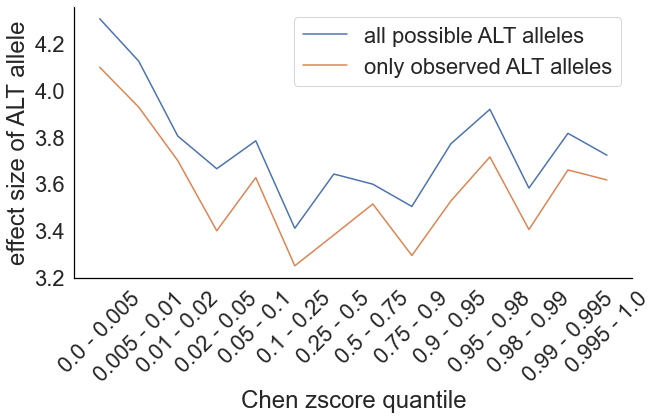

In [10]:
plt.rcParams.update({
  'figure.figsize': (10, 5),
  # 'axes.facecolor': 'white'
})

def plot_mean_effect_sizes(): 
  quantiles = []
  mean_effect_size_for_all_ALTs = []
  mean_effect_size_for_ALTS_in_cohort = []
  for quantile in ALT_effect_size_all_windows.keys(): 
    quantiles.append(quantile)

    effect_sizes = np.array(ALT_effect_size_all_windows[quantile])

    ALT_exists = ALT_exists_in_cohort_all_windows[quantile]
    ALT_exists = np.array(ALT_exists, dtype=bool)

    mean_effect_size_for_all_ALTs.append(np.mean(effect_sizes))
    mean_effect_size_for_ALTS_in_cohort.append(np.mean(effect_sizes[ALT_exists]))

  plt.plot(quantiles, mean_effect_size_for_all_ALTs, label='all possible ALT alleles')
  plt.plot(quantiles, mean_effect_size_for_ALTS_in_cohort, label='only observed ALT alleles')
  plt.xticks(rotation = 45) 
  plt.gca().spines['bottom'].set_color('black')
  plt.gca().spines['left'].set_color('black')
  plt.legend() 
  plt.ylabel('effect size of ALT allele')
  plt.xlabel('Chen zscore quantile')

plot_mean_effect_sizes()

EFFECT_SIZE_THRESHOLD: 11
[[  359    18]
 [27653  1970]] 0.0 - 0.005 1.420842424169369 0.08379996092645034
[[  256    12]
 [27786  1946]] 0.005 - 0.01 1.4940857506178171 0.10307105763186086
[[  214    21]
 [27939  1826]] 0.01 - 0.02 0.6660155883821727 0.9665169179367852
[[  217     6]
 [27984  1793]] 0.02 - 0.05 2.31728249475891 0.017787383646399375
[[  270    11]
 [27958  1761]] 0.05 - 0.1 1.5460528455020193 0.09213031130840345
[[  210    13]
 [28001  1776]] 0.1 - 0.25 1.024578792515652 0.5392071688983141
[[  193     7]
 [27985  1815]] 0.25 - 0.5 1.7881773399014778 0.07613500236292185
[[  222    13]
 [27860  1905]] 0.5 - 0.75 1.167679054613728 0.3537242614588986
[[  223    18]
 [27597  2162]] 0.75 - 0.9 0.9705684595346515 0.6097620810382861
[[  317    17]
 [27394  2272]] 0.9 - 0.95 1.546547333250304 0.04316328822233048
[[  317    30]
 [27099  2554]] 0.95 - 0.98 0.9958768466241067 0.5569780998818703
[[  183    17]
 [27151  2649]] 0.98 - 0.99 1.050263558703287 0.4863428627028089
[[  309

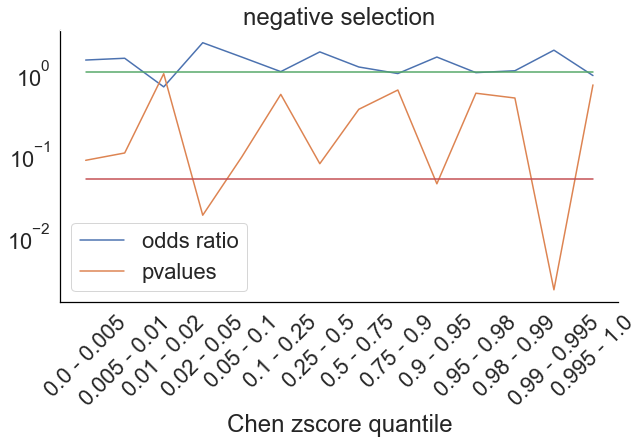

In [11]:
def plot_enrichment_in_strong_alleles(test): 
  print(f'EFFECT_SIZE_THRESHOLD: {EFFECT_SIZE_THRESHOLD}')
  
  quantiles = []
  odds_ratios = []
  pvalues = []
  for quantile in ALT_effect_size_all_windows.keys(): 
    quantiles.append(quantile)

    effect_sizes = np.array(ALT_effect_size_all_windows[quantile])

    ALT_exists = ALT_exists_in_cohort_all_windows[quantile]
    ALT_exists = np.array(ALT_exists, dtype=bool)

    ALT_is_strong = effect_sizes>EFFECT_SIZE_THRESHOLD

    if test == 'negative selection': 
      table = np.array(pd.crosstab(np.logical_not(ALT_is_strong), ALT_exists))
    elif test == 'positive selection': 
      table = np.array(pd.crosstab(np.logical_not(ALT_is_strong), np.logical_not(ALT_exists)))
    else: 
      raise ValueError
    
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html
    result = fisher_exact(table, alternative='greater')
    odds_ratio, pvalue = result.statistic, result.pvalue

    print(table, quantile, odds_ratio, pvalue)

    odds_ratios.append(odds_ratio)
    pvalues.append(pvalue)

  plt.plot(quantiles, odds_ratios, label='odds ratio')
  plt.plot(quantiles, pvalues, label='pvalues')
  plt.plot(quantiles, [1]*len(quantiles))
  plt.plot(quantiles, [0.05]*len(quantiles))
  plt.xticks(rotation = 45) 
  plt.gca().spines['bottom'].set_color('black')
  plt.gca().spines['left'].set_color('black')
  plt.legend() 
  plt.ylabel(None)
  plt.xlabel('Chen zscore quantile')
  plt.title(test)
  plt.yscale('log')

plot_enrichment_in_strong_alleles(test='negative selection')

EFFECT_SIZE_THRESHOLD: 11
[[   18   359]
 [ 1970 27653]] 0.0 - 0.005 0.7038078135825686 0.9462842753662949
[[   12   256]
 [ 1946 27786]] 0.005 - 0.01 0.6693056269270298 0.9385095536426843
[[   21   214]
 [ 1826 27939]] 0.01 - 0.02 1.501466358211094 0.05596401672107122
[[    6   217]
 [ 1793 27984]] 0.02 - 0.05 0.4315399621158576 0.9930855414026798
[[   11   270]
 [ 1761 27958]] 0.05 - 0.1 0.6468084211411866 0.946905966432887
[[   13   210]
 [ 1776 28001]] 0.1 - 0.25 0.9760108322608323 0.5740867583284914
[[    7   193]
 [ 1815 27985]] 0.25 - 0.5 0.559228650137741 0.9626283200726575
[[   13   222]
 [ 1905 27860]] 0.5 - 0.75 0.8563997067934076 0.7436358305627412
[[   18   223]
 [ 2162 27597]] 0.75 - 0.9 1.0303240231806623 0.48722844241524343
[[   17   317]
 [ 2272 27394]] 0.9 - 0.95 0.6466016128315635 0.9743449194526154
[[   30   317]
 [ 2554 27099]] 0.95 - 0.98 1.0041402241550954 0.5194411537117916
[[   17   183]
 [ 2649 27151]] 0.98 - 0.99 0.9521419568576244 0.612750445915734
[[   20  

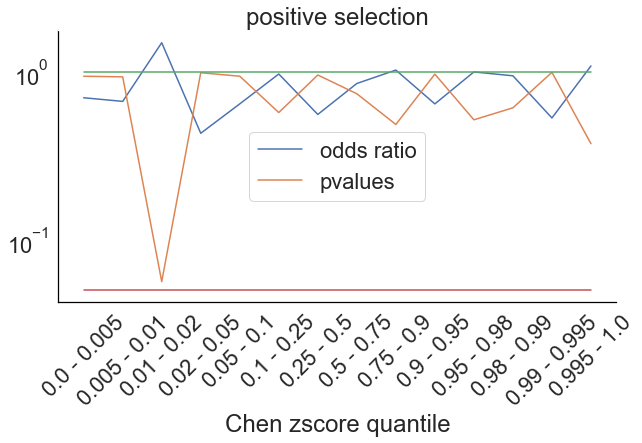

In [12]:
plot_enrichment_in_strong_alleles(test='positive selection')